In [1]:
import torch
import torch.nn as nn
import json
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from configs.dataloaders import create_data_loaders
from runner_static import static_training
from runner_dynamic import dynamic_training
from models.static_models.static_model_multibranch import StaticModelMultibranch
from models.dynamic_models.lstm_model import LSTMDynamicModel
from trainers.cross_validation import k_fold_cross_validation_static, k_fold_cross_validation_dynamic
from losses.losses import CrossEntropy, CrossEntropyWithLasso, CrossEntropyWithTemporalSmoothness

# Static Model

The main goal of this first part is to try different architectures and select the one that performs better for the **static protein localization problem**.

We start by initializing all the indispensable variables and loading hyperparameters from `hyperparameters.json`. From now on, all the  __bold_variables__ are to be considered as taken from this JSON file.

In [2]:
# Initialize random seed
seed = 30026
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Define dimensions of the problem
num_classes = 15
num_timesteps = 5
num_features = 34 # both static and dynamic

# Decide whever to be verbose with display outputs and set device
verbose = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define hyperparameters
with open('hyperparameters/hyperparameters.json', 'r') as file:
    params = json.load(file)

static_params = params["static_model"]

# Load file
data = pd.read_csv(params["file_path"])

Since our models will be combined together for creating more complex models, we split data in train and validation sets once and for all before creating all models: in this way, we avoid the risk of using the same samples for train and for validate at the same time.

In [4]:
# Split dataset in train and test sets keeping balance for the static label localization
data_train, data_test = train_test_split(data, test_size=params["test_size"], random_state=seed, stratify = data['static_localization'])

# Create dataloaders
dataloader_train, dataloader_test = create_data_loaders(data_train, data_test, params["batch_size"])

## First Model: Multi-Layer-Perceptron

Our first try is a simple MLP with just a hidden layer of size __intermediate_dim__, which takes as input the ESM-embeddings (you can choose between small and big embeddings with __long_embeddings__ boolean variable, depending on computational availabilities).

We are using techniques for regularization which will be present in all our architectures: dropout, weight_decay, early stopping, layer normalization, weight initialization, learning rate scheduler.

In this first phase, we only try some reasonable hyperparameters choices: because of high compuational costs, we cannot do cross-validation on all the hyperparameters for all the models, but we will do it for our best static model.

Starting training of StaticModelMLP
Epoch [1/100],	Training Loss: 1.7331, Training accuracy: 42.29,	Test Loss: 1.4622, Test Accuracy: 50.92,	Learning rate: 0.01000
Epoch [2/100],	Training Loss: 1.4092, Training accuracy: 51.18,	Test Loss: 1.3740, Test Accuracy: 52.05,	Learning rate: 0.01000
Epoch [3/100],	Training Loss: 1.3264, Training accuracy: 54.39,	Test Loss: 1.3400, Test Accuracy: 54.58,	Learning rate: 0.01000
Epoch [4/100],	Training Loss: 1.2435, Training accuracy: 57.14,	Test Loss: 1.3544, Test Accuracy: 53.88,	Learning rate: 0.01000
Epoch [5/100],	Training Loss: 1.1846, Training accuracy: 59.26,	Test Loss: 1.2880, Test Accuracy: 54.87,	Learning rate: 0.01000
Epoch [6/100],	Training Loss: 1.1385, Training accuracy: 60.21,	Test Loss: 1.2873, Test Accuracy: 56.84,	Learning rate: 0.01000
Epoch [7/100],	Training Loss: 1.0913, Training accuracy: 61.06,	Test Loss: 1.3206, Test Accuracy: 53.88,	Learning rate: 0.01000
Epoch [8/100],	Training Loss: 1.0427, Training accuracy: 63.14,	Test

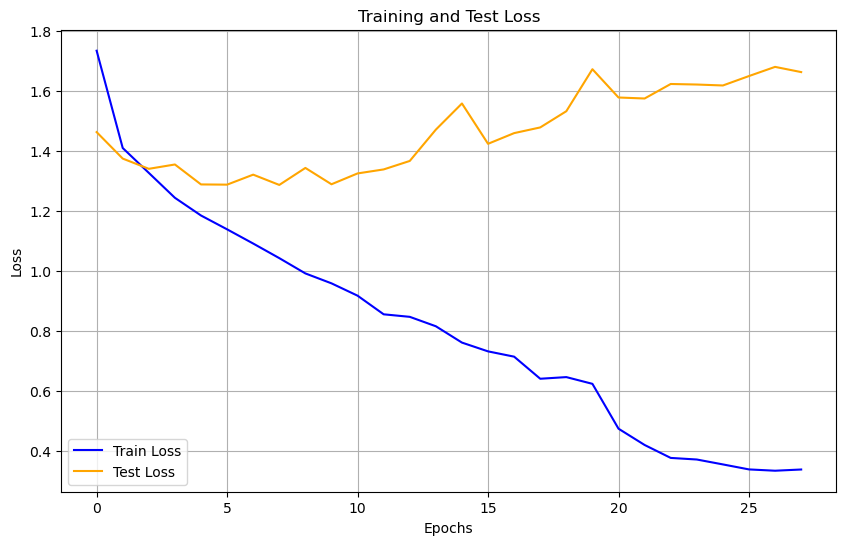

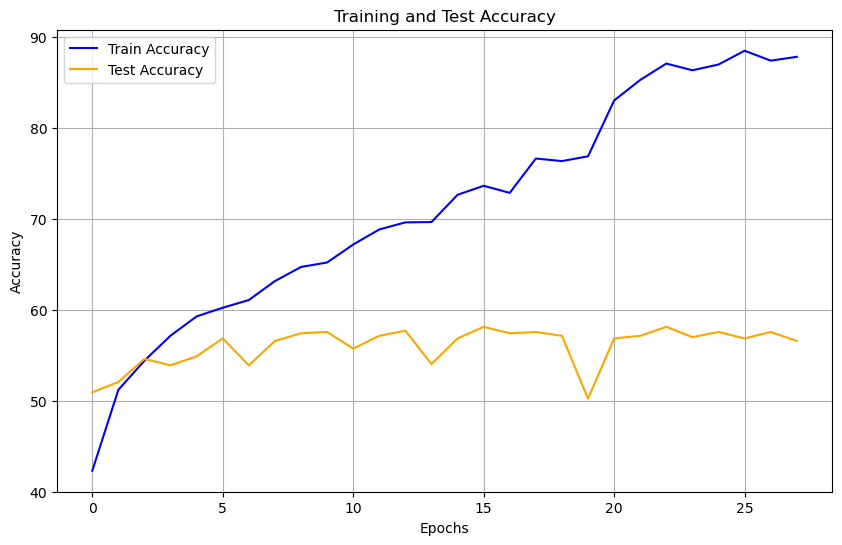

In [8]:
# Running the first model
train_loss, train_accuracy, test_loss, test_accuracy, static_model_dict = static_training(num_classes, static_params, dataloader_train, dataloader_test, verbose, device)

Even though we have used some technique like __dropout__, __weight_decay__ and early stopping (set with __patience__ parameter), this model appears to strongly overfit. 

## Second Model: XGBoost

Commento di Riki aaaaaa

Since XGBoost has a different architecture, we will use an appositely create JSON file `hyperparametersxgb.json`.

In [10]:
# Define hyperparameters
with open('hyperparametersxgb.json', 'r') as file:
    xgb_params = json.load(file)

xgb_params = xgb_params["static_model"]

Starting training of XGBoost
[0]	train-mlogloss:2.70180	train-merror:0.37500	test-mlogloss:2.70669	test-merror:0.81250


[25]	train-mlogloss:2.55404	train-merror:0.34375	test-mlogloss:2.66291	test-merror:0.75000
[50]	train-mlogloss:2.42204	train-merror:0.34375	test-mlogloss:2.61855	test-merror:0.75000
[75]	train-mlogloss:2.30472	train-merror:0.34375	test-mlogloss:2.58300	test-merror:0.75000
[100]	train-mlogloss:2.19836	train-merror:0.37500	test-mlogloss:2.55792	test-merror:0.71875
[125]	train-mlogloss:2.10559	train-merror:0.37500	test-mlogloss:2.53734	test-merror:0.71875
[150]	train-mlogloss:2.02557	train-merror:0.37500	test-mlogloss:2.51902	test-merror:0.68750
[175]	train-mlogloss:1.95740	train-merror:0.37500	test-mlogloss:2.50267	test-merror:0.68750
[200]	train-mlogloss:1.91222	train-merror:0.37500	test-mlogloss:2.48511	test-merror:0.68750
[225]	train-mlogloss:1.87771	train-merror:0.37500	test-mlogloss:2.46554	test-merror:0.68750
[250]	train-mlogloss:1.84771	train-merror:0.37500	test-mlogloss:2.44755	test-merror:0.68750
[275]	train-mlogloss:1.82149	train-merror:0.37500	test-mlogloss:2.43197	test-merror

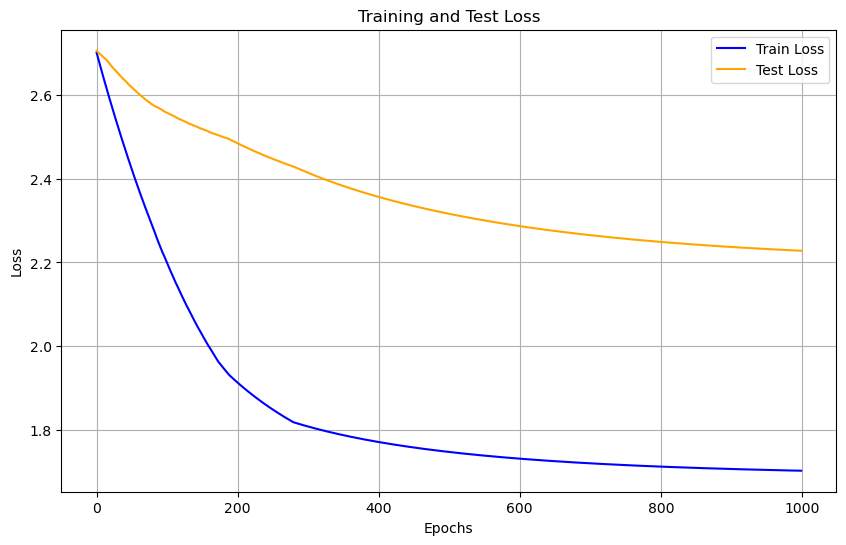

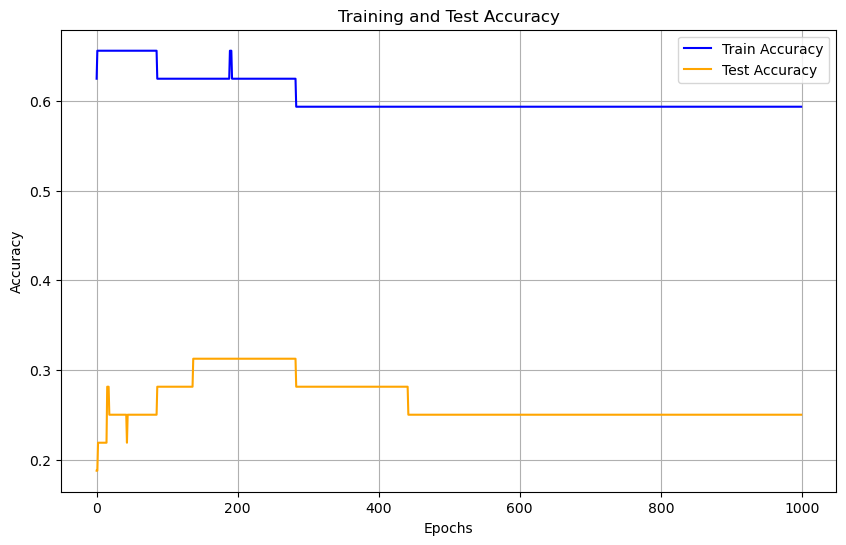

In [9]:
# Running the second model
train_loss, train_accuracy, test_loss, test_accuracy, static_model_dict = static_training(num_classes, xgb_params, dataloader_train, dataloader_test, verbose, device)

## Third Model: StaticModelMultibranch

The last static models is created with more complex architecture: since from biological analysis we expect the first and last amino acids of each sequence to be the most representative for our task, this neural networks takes as input also the strings of first and last 20 amino acids of each sequence. These strings are embedded by some transformer layers and then given to some MLP layer together with ESM-embeddings.

### Training

In [9]:
# Change model_type for running the right model (from 0 to 2, for more info look at static_training inside runner_static.py)
static_params["model_type"] +=2

Starting training of StaticModelMultibranch
Epoch [1/100],	Training Loss: 2.3416, Training accuracy: 29.95,	Test Loss: 1.7508, Test Accuracy: 36.67,	Learning rate: 0.01000
Epoch [2/100],	Training Loss: 1.7370, Training accuracy: 38.98,	Test Loss: 1.5143, Test Accuracy: 47.53,	Learning rate: 0.01000
Epoch [3/100],	Training Loss: 1.6277, Training accuracy: 43.81,	Test Loss: 1.5406, Test Accuracy: 43.44,	Learning rate: 0.01000
Epoch [4/100],	Training Loss: 1.5659, Training accuracy: 46.70,	Test Loss: 1.4713, Test Accuracy: 50.92,	Learning rate: 0.01000
Epoch [5/100],	Training Loss: 1.5042, Training accuracy: 48.68,	Test Loss: 1.4245, Test Accuracy: 49.65,	Learning rate: 0.01000
Epoch [6/100],	Training Loss: 1.4535, Training accuracy: 50.37,	Test Loss: 1.3889, Test Accuracy: 51.62,	Learning rate: 0.01000
Epoch [7/100],	Training Loss: 1.4219, Training accuracy: 50.93,	Test Loss: 1.3577, Test Accuracy: 52.47,	Learning rate: 0.01000
Epoch [8/100],	Training Loss: 1.3939, Training accuracy: 52.

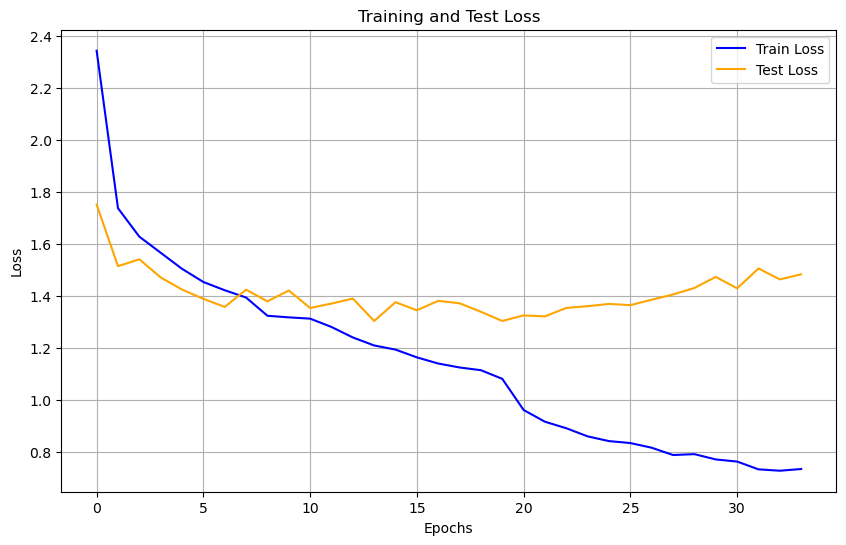

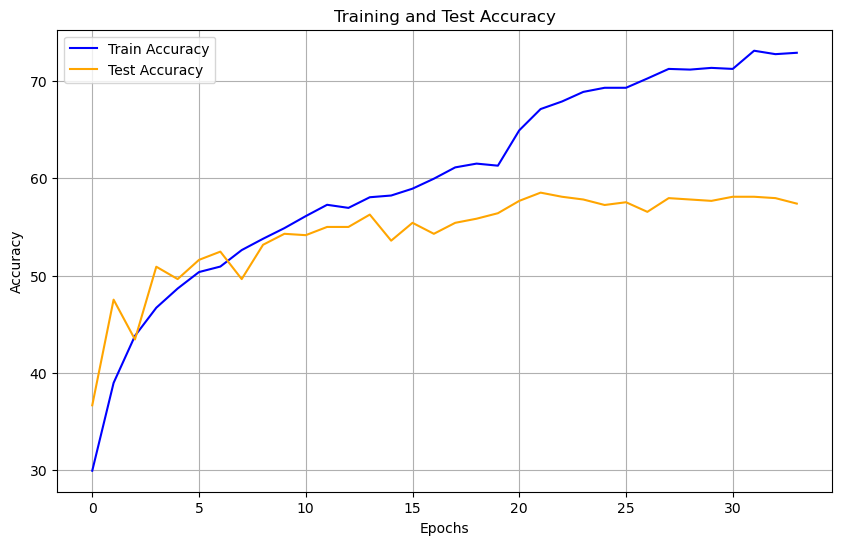

In [10]:
# Running the third model
train_loss, train_accuracy, test_loss, test_accuracy, static_model_dict = static_training(num_classes, static_params, dataloader_train, dataloader_test, verbose, device)

By analyzing our main metrics (validation loss and validation accuracy) and the behavior in terms of overfitting, we can conclude that this is the best static model we have created.
For this reason, we perform k-fold cross-validation for finding the best hyperparameters of our model.

### K-Fold Cross validation

In [ ]:
# Choose parameters for grid cross-validation
parameter_grid = {
    "dropout": [0, 0.25, 0.5],
    "learning_rate": [0.001, 0.01],
    "weight_decay": [0, 0.0001, 0.01],
    "scheduler": ['CosineAnnealingLR', 'StepLR', 'ExponentialLR']
}

# Setting principal fixed parameters for k-fold (i.e. number of folds and metric to use for choosing best model)
k_folds = 3
cross_validation_on_loss = True

best_params, results = k_fold_cross_validation_static(
    StaticModelMultibranch,
    data,
    CrossEntropy,
    parameter_grid,
    static_params["num_epochs"],
    static_params["patience"],
    params["batch_size"],
    device,
    k_folds=k_folds,
    seed=seed,
    cross_validation_on_loss=cross_validation_on_loss,
    verbose=True
)

In [ ]:
# We save best results in a json file for using them in a second moment
results_file = 'hyperparameters/cross_val_results_static'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=4)

best_file = 'hyperparameters/best_results_static'
with open(best_file, 'w') as f:
    json.dump(best_params, f, indent=4)

Starting from this parameters, we create a new `hyperparameters_cross_validation.json` file for running our best model on the hyperparameters obtained with 3-fold cross-validation. The result of this training will be our best static architecture and will be used in the second part of the project.

In [5]:
# Load hyperparameters
with open('hyperparameters/hyperparameters_cross_val.json', 'r') as file:
    params = json.load(file)

static_params = params["static_model"]

# Set embedding dimensions based on json parameter
if static_params["long_embeddings"]:
    embedding_dim = 640
else:
    embedding_dim = 320

Starting training of StaticModelMultibranch
Epoch [1/100],	Training Loss: 2.3817, Training accuracy: 28.96,	Test Loss: 1.8273, Test Accuracy: 37.80,	Learning rate: 0.00100
Epoch [2/100],	Training Loss: 1.8299, Training accuracy: 37.85,	Test Loss: 1.6242, Test Accuracy: 43.58,	Learning rate: 0.00100
Epoch [3/100],	Training Loss: 1.6489, Training accuracy: 43.53,	Test Loss: 1.4827, Test Accuracy: 47.81,	Learning rate: 0.00100
Epoch [4/100],	Training Loss: 1.5480, Training accuracy: 47.37,	Test Loss: 1.4253, Test Accuracy: 50.35,	Learning rate: 0.00100
Epoch [5/100],	Training Loss: 1.4712, Training accuracy: 50.19,	Test Loss: 1.3841, Test Accuracy: 52.47,	Learning rate: 0.00100
Epoch [6/100],	Training Loss: 1.4236, Training accuracy: 52.70,	Test Loss: 1.3824, Test Accuracy: 51.20,	Learning rate: 0.00100
Epoch [7/100],	Training Loss: 1.3812, Training accuracy: 53.37,	Test Loss: 1.3482, Test Accuracy: 52.89,	Learning rate: 0.00100
Epoch [8/100],	Training Loss: 1.3297, Training accuracy: 54.

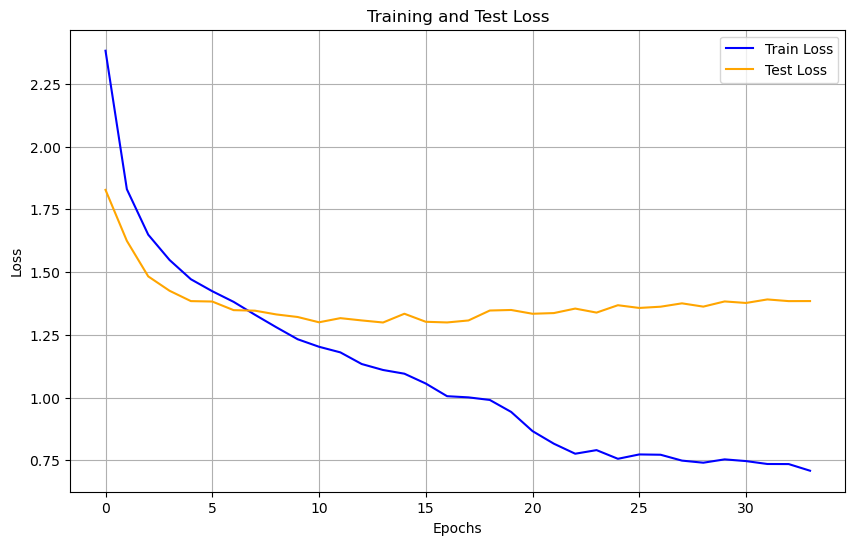

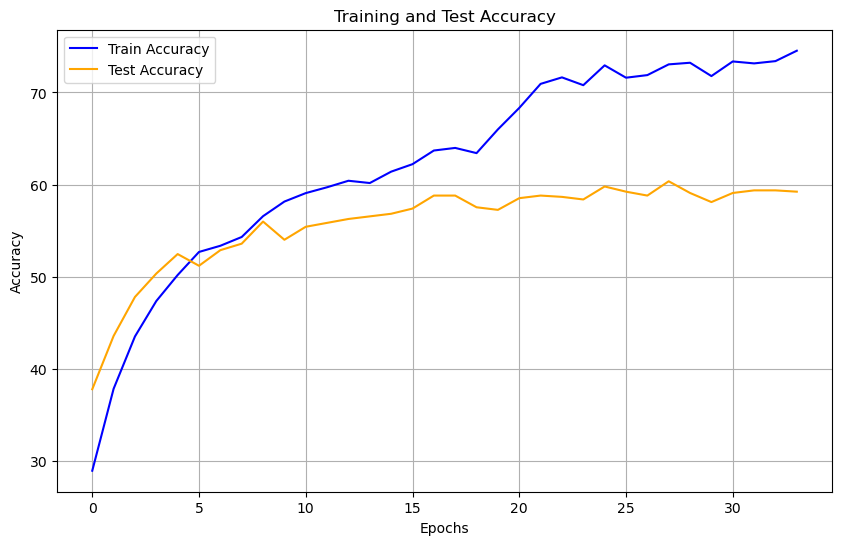

In [6]:
# Running the third model
train_loss, train_accuracy, test_loss, test_accuracy, static_model_dict = static_training(num_classes, static_params, dataloader_train, dataloader_test, verbose, device)

In [ ]:
# Save best model
best_static_model = StaticModelMultibranch(num_classes=num_classes, embedding_dim=embedding_dim, extremities_dim=20, char_vocab_size=20, char_embed_dim=16, intermediate_dim=static_params["intermediate_dim"], dropout=static_params["dropout"])

# Load the weights from the dictionary
best_static_model.load_state_dict(static_model_dict)

<All keys matched successfully>

# Dynamic Model

In this second part, we try to solve the dynamic counterpart of the localization problem: every protein can now change position during eukaryotic cell cycle, which consists of 5 different timesteps.

## First Model: LSTMDynamicModel

The first model consists of a LSTM architecture which takes as input the dynamic data and the output of the StaticModelMultibranch static model.

In [8]:
# Load hyperparameters
dynamic_params = params["dynamic_model"]

Starting training of LSTMDynamicModel
Epoch [1/100],	Training Loss: 1.8943, Training accuracy: 37.95,	Test Loss: 1.7395, Test Accuracy: 47.08,	Learning rate: 0.00100
Epoch [2/100],	Training Loss: 1.2698, Training accuracy: 58.98,	Test Loss: 1.5588, Test Accuracy: 54.50,	Learning rate: 0.00100
Epoch [3/100],	Training Loss: 1.1127, Training accuracy: 64.35,	Test Loss: 1.4961, Test Accuracy: 54.95,	Learning rate: 0.00100
Epoch [4/100],	Training Loss: 1.0494, Training accuracy: 66.31,	Test Loss: 1.4771, Test Accuracy: 55.74,	Learning rate: 0.00100
Epoch [5/100],	Training Loss: 1.0242, Training accuracy: 67.76,	Test Loss: 1.4700, Test Accuracy: 56.61,	Learning rate: 0.00100
Epoch [6/100],	Training Loss: 0.9778, Training accuracy: 70.65,	Test Loss: 1.3960, Test Accuracy: 58.00,	Learning rate: 0.00100
Epoch [7/100],	Training Loss: 0.9579, Training accuracy: 71.36,	Test Loss: 1.4611, Test Accuracy: 57.66,	Learning rate: 0.00100
Epoch [8/100],	Training Loss: 0.9442, Training accuracy: 71.32,	Te

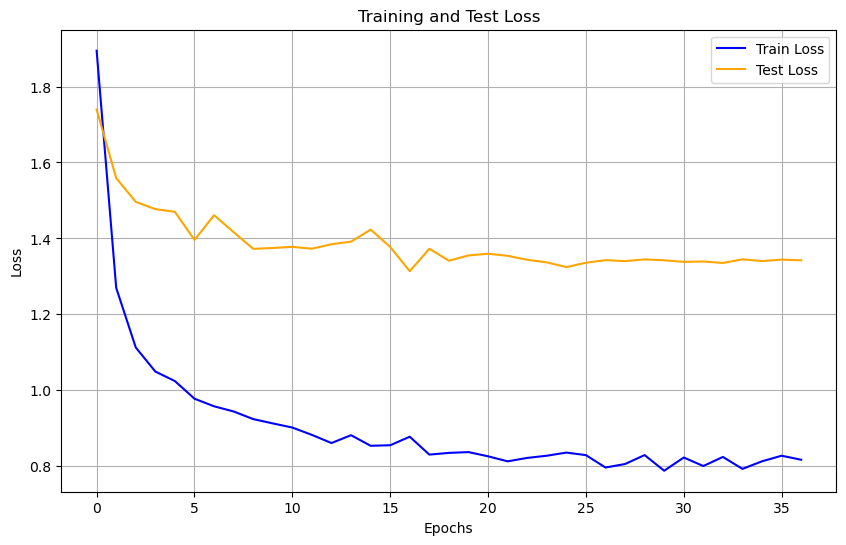

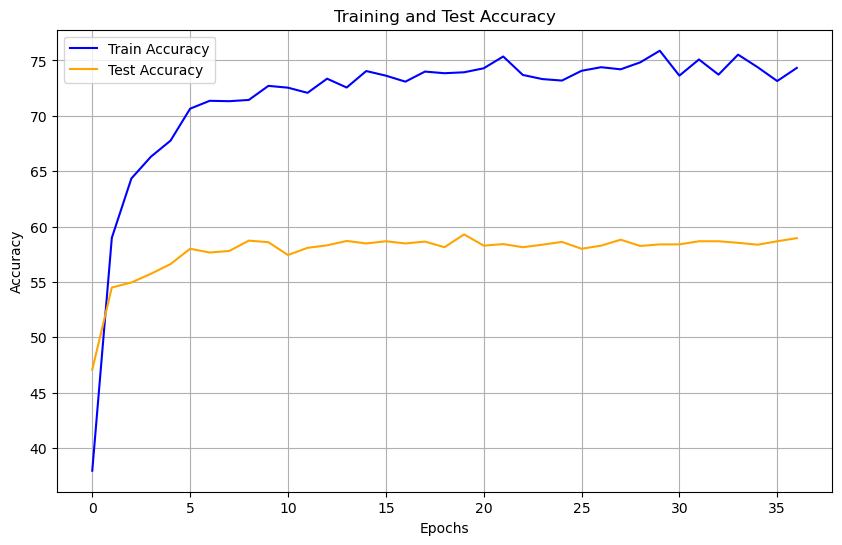

In [9]:
# Run training
train_loss, train_accuracy, test_loss, test_accuracy, lstm_dynamic_model = dynamic_training(num_features, num_classes, num_timesteps, embedding_dim, dynamic_params, best_static_model, dataloader_train, dataloader_test, verbose, device)

## Second Model: TCNModel

In [10]:
# Change model_type for running the right model (from 0 to 1, for more info look at dynamic_training inside runner_dynamic.py)
dynamic_params["model_type"] +=1

Starting training of TCNDynamicModel
Epoch [1/100],	Training Loss: 1.8005, Training accuracy: 39.52,	Test Loss: 1.4539, Test Accuracy: 54.75,	Learning rate: 0.00100
Epoch [2/100],	Training Loss: 1.3470, Training accuracy: 55.35,	Test Loss: 1.3867, Test Accuracy: 55.20,	Learning rate: 0.00100
Epoch [3/100],	Training Loss: 1.2171, Training accuracy: 60.29,	Test Loss: 1.3681, Test Accuracy: 57.46,	Learning rate: 0.00100
Epoch [4/100],	Training Loss: 1.1343, Training accuracy: 61.94,	Test Loss: 1.2846, Test Accuracy: 59.58,	Learning rate: 0.00100
Epoch [5/100],	Training Loss: 1.0588, Training accuracy: 64.21,	Test Loss: 1.3477, Test Accuracy: 59.15,	Learning rate: 0.00100
Epoch [6/100],	Training Loss: 0.9958, Training accuracy: 66.94,	Test Loss: 1.3375, Test Accuracy: 58.82,	Learning rate: 0.00100
Epoch [7/100],	Training Loss: 0.9633, Training accuracy: 67.29,	Test Loss: 1.3150, Test Accuracy: 59.69,	Learning rate: 0.00100
Epoch [8/100],	Training Loss: 0.8904, Training accuracy: 69.15,	Tes

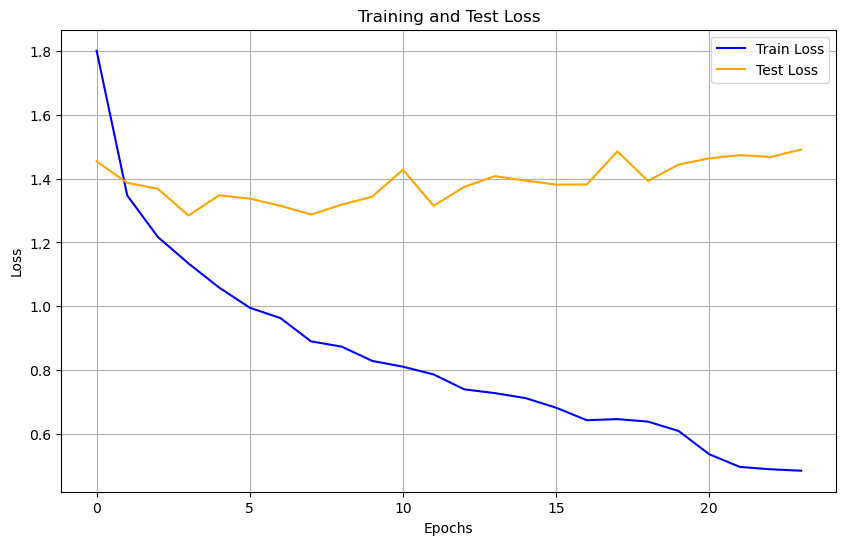

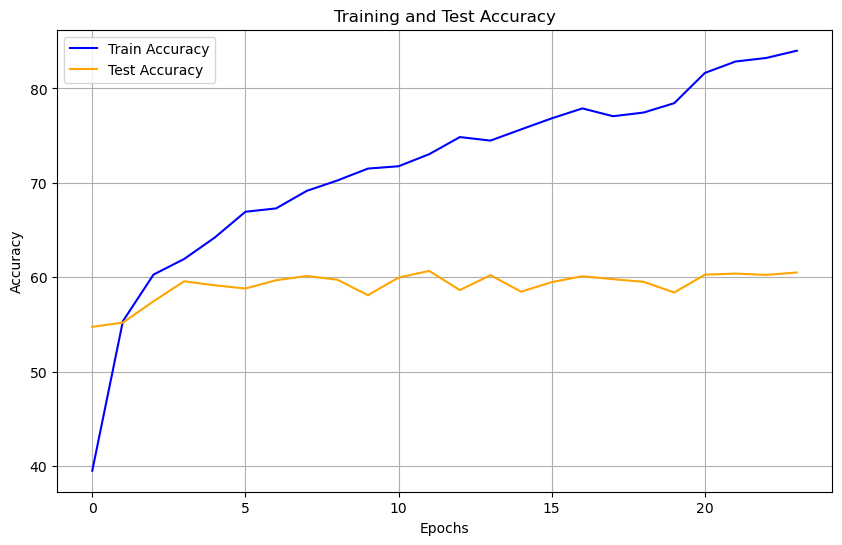

In [ ]:
# Run training
train_loss, train_accuracy, test_loss, test_accuracy, dynamic_model = dynamic_training(num_features, num_classes, num_timesteps, embedding_dim, dynamic_params, best_static_model, dataloader_train, dataloader_test, verbose, device)

## Third Model: SimpleModel

In [12]:
# Change model_type for running the right model (from 1 to 2, for more info look at dynamic_training inside runner_dynamic.py)
dynamic_params["model_type"] +=1

Starting training of SimpleDynamicModel
Epoch [1/100],	Training Loss: 2.0316, Training accuracy: 32.96,	Test Loss: 1.8351, Test Accuracy: 38.67,	Learning rate: 0.00100
Epoch [2/100],	Training Loss: 1.7627, Training accuracy: 40.25,	Test Loss: 1.7207, Test Accuracy: 41.30,	Learning rate: 0.00100
Epoch [3/100],	Training Loss: 1.6638, Training accuracy: 43.08,	Test Loss: 1.6523, Test Accuracy: 41.24,	Learning rate: 0.00100
Epoch [4/100],	Training Loss: 1.5875, Training accuracy: 46.97,	Test Loss: 1.5945, Test Accuracy: 45.36,	Learning rate: 0.00100
Epoch [5/100],	Training Loss: 1.5337, Training accuracy: 48.99,	Test Loss: 1.5590, Test Accuracy: 45.70,	Learning rate: 0.00100
Epoch [6/100],	Training Loss: 1.4924, Training accuracy: 50.97,	Test Loss: 1.5256, Test Accuracy: 47.79,	Learning rate: 0.00100
Epoch [7/100],	Training Loss: 1.4590, Training accuracy: 52.02,	Test Loss: 1.5005, Test Accuracy: 49.17,	Learning rate: 0.00100
Epoch [8/100],	Training Loss: 1.4309, Training accuracy: 53.48,	

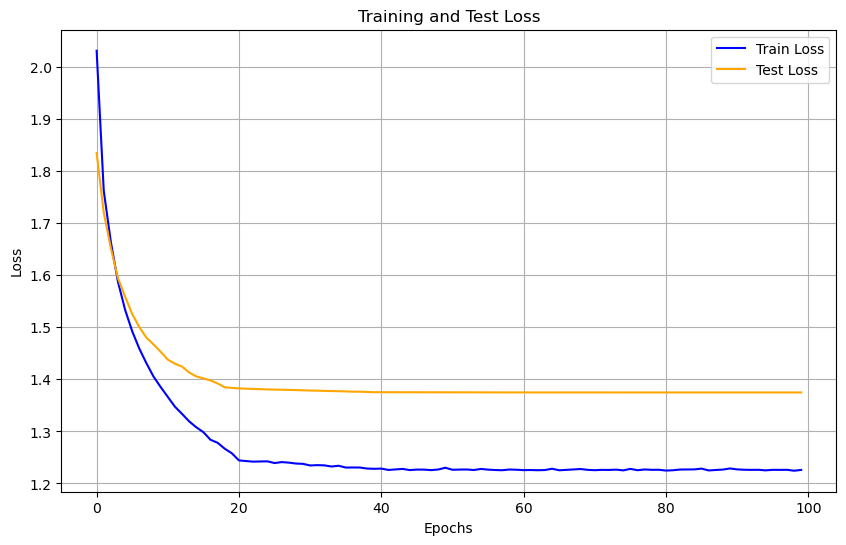

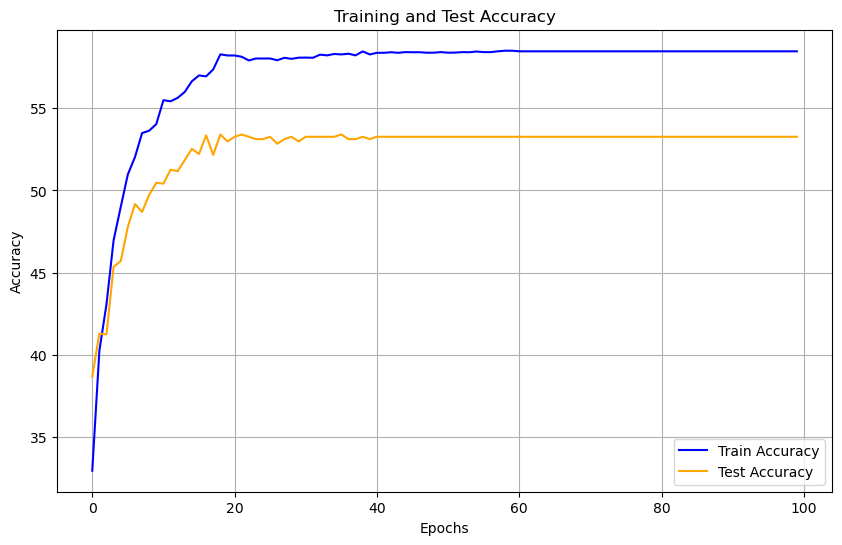

In [ ]:
# Run training
train_loss, train_accuracy, test_loss, test_accuracy, model = dynamic_training(num_features, num_classes, num_timesteps, embedding_dim, dynamic_params, best_static_model, dataloader_train, dataloader_test, verbose, device)

Important remarks can be done on this model: since it is not accounting for temporal relationships between data, it is not performing as well as the other models (as expected). However, it is still learning relatively well. This can be caused by the fact that ESM-embeddings are the most usefull data we have in our dataset, since they are obtained from elaborated architecture pre-trained on milions of proteins.

## K-Fold Cross-Validation on LSTM Model

Since LSTM is the model which performs best, we run cross validation for its hyperparameters

In [ ]:
# Choosing hyperparameters
parameter_grid = {
    "dropout": [0.2],
    "learning_rate": [0.001, 0.01],
    "weight_decay": [0.01],
    "scheduler": ['StepLR'],
    "lambda_penalty": [0, 1e-5, 1e-2],
    "static_learnable": [True, False],
    "hidden_size": [32, 64]
}

# Load best parameters for static model
with open('hyperparameters/best_results_static.json', 'r') as file:
    best_params_static = json.load(file)


best_params, results = k_fold_cross_validation_dynamic(
    StaticModelMultibranch,
    LSTMDynamicModel,
    data,
    CrossEntropyWithTemporalSmoothness,
    parameter_grid,
    best_params_static,
    dynamic_params["num_epochs"],
    dynamic_params["patience"],
    params["batch_size"],
    device,
    k_folds=3,
    seed=seed,
    cross_validation_on_loss=True,
    verbose=True
)

results_file = 'hyperparameters/cross_val_results_dynamic.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=4)

best_file = 'hyperparameters/best_results_dynamic.json'
with open(best_file, 'w') as f:
    json.dump(best_params, f, indent=4)

## Towards Intepretability: Modulable LSTM Model

Now that we have selected our best model, we try to interpret the results. Apart from correctly predicting protein locations, the main question of our problem is whether all different data are equally important for this task.

Moving in this direction, we make the LSTM Module modulable: it can be trained on the whole dataset or only on part of it (in particular it can decide wheter to take __protein interactions matrix__, __protein concentration levels__ and __static_data__, with all the possible combinations available). As all other hyperparameters choice, refer to the `hyperparameters_cross_val.json` file.

You can modify the three parameters there and afterwards run the following cells

In [21]:
# Define hyperparameters
with open('hyperparameters/hyperparameters_cross_val.json', 'r') as file:
    params = json.load(file)

dynamic_params = params["dynamic_model"]

# Set embedding dimensions based on json parameter
if static_params["long_embeddings"]:
    embedding_dim = 640
else:
    embedding_dim = 320

In [ ]:
# Run training
train_loss, train_accuracy, test_loss, test_accuracy, model = dynamic_training(num_features, num_classes, num_timesteps, embedding_dim, dynamic_params, best_static_model, dataloader_train, dataloader_test, verbose, device)

Results of these multiple runs are given in detail on the report